In [1]:
import json
import regex
import base64
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
import geopandas as gpd
import folium
import re
import geopy
import sklearn
#import shutil
import math

C:\Users\peria\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Copia il file di origine nel percorso di destinazione
#original_file = r'C:\Users\peria\Desktop\Project\Elba\AirBnB_Input_Elba\Input51.json'
#for j in range(int(original_file[-7:9]), 71):
#    shutil.copy2(original_file, 
#                 r'C:\Users\peria\Desktop\Project\Elba\AirBnB_Input_Elba\Input' + str(j) + '.json')

# Comprendere i raw data del file .json

Dentro le chiavi "staysSearch" e "staysMapSearch" ci sono più o meno le stesse informazioni, quindi andarle a pescare da una o dall'altra fonte non cambierà molto.

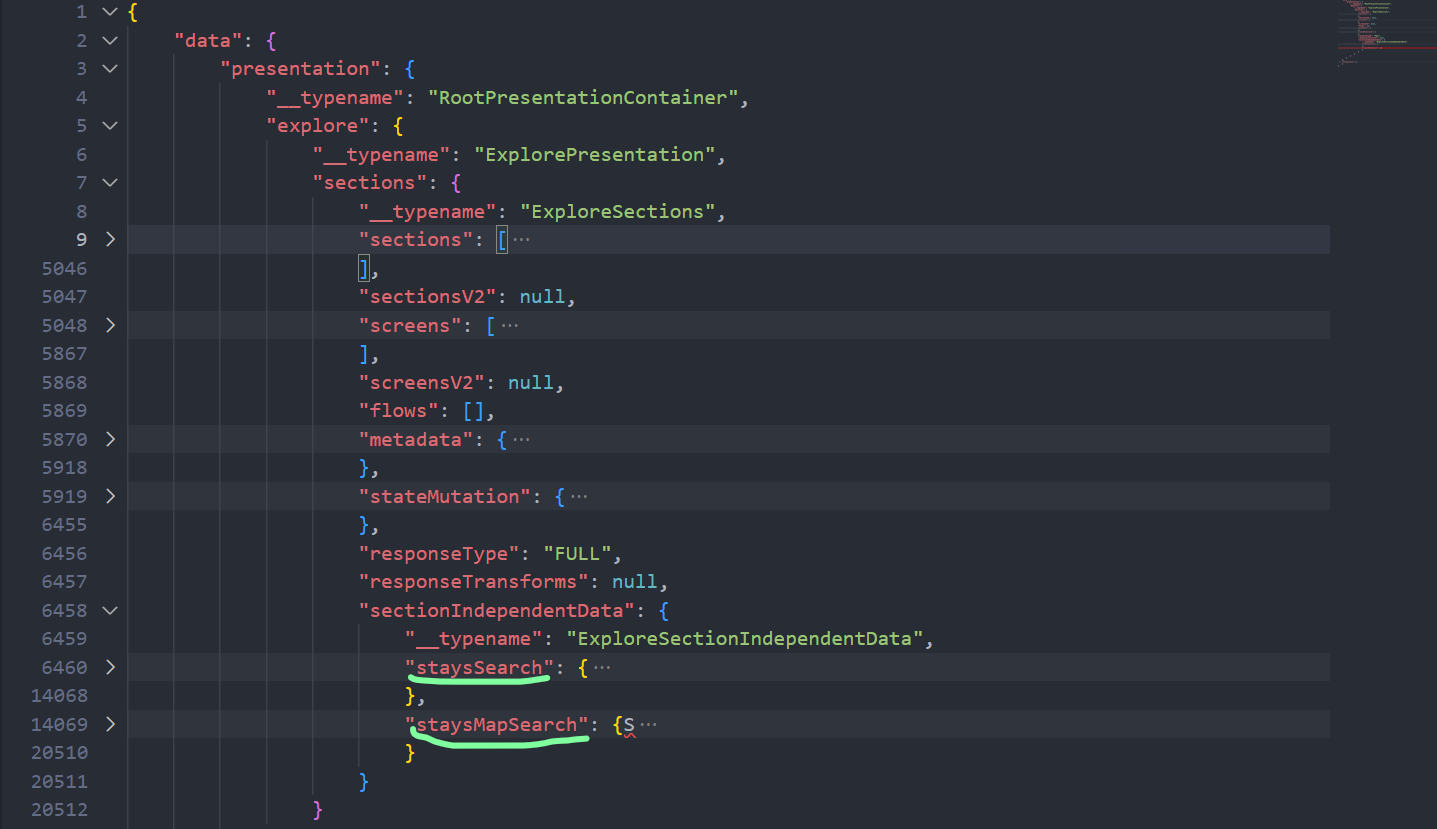

Tutto partirà da **list_annunci** ovvero l'insieme di tutti gli annunci che sono stati visualizzati su AirBnB.

Ogni risultato al suo interno ha 3 principali chiavi:
- **listing**
- **listingParamOverrides**
- **pricingQuote**

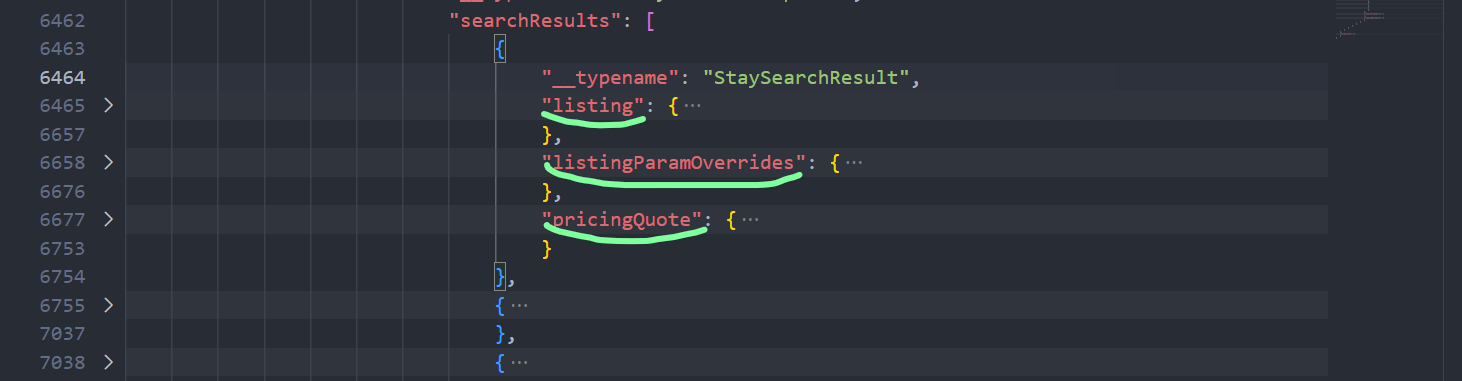

Considerando che ogni risultato dentro **list_results** lo chiamo **result**, io sono interessato a:

- result['listing']['city'] --> str
-result['listing']['name'] --> str
- result['listing']['avgRatingLocalized'] --> str
- result['listing']['contextualPictures'] --> list --> da qui estraggo le amenities che vedo nelle foto 
- result['listing']['contextualPictures']['picture']--> str --> (se presente) link che corrisponde alla foto mostrata
- result['listing']['contextualPictures']['caption']['messages'] --> (se presente) list con le amenities mostrare nella foto
- result['listing']['contextualPictures']['contextualPicturesCount'] --> int --> numero di foto esposte nell'annuncio 
- result['listing']['coordinate']['latitude'] --> float  
- result['listing']['coordinate']['longitude'] --> float  
- result['listing']['id'] --> int --> id dell'annuncio  
- result['listing']['roomTypeCategory'] --> str --> è l'oggetto dell'annuncio, ovvero cosa viene affittato 
- result['listing']['structuredContent']['primaryLine']['body'] --> str --> intestatario dell'annuncio
- result['listing']['title'] --> str --> titolo dell'annuncio 
- result['listingParamOverrides']['checkin'] --> str
- result['listingParamOverrides']['checkout'] --> str
- result['pricingQuote']['rate']['amount'] --> float --> prezzo giornaliero chiavi in mano
- result['pricingQuote']['structuredStayDisplayPrice']['primaryLine']['accessibilityLabel'] --> quanto si spende a notte
- result['pricingQuote']['structuredStayDisplayPrice']['secondaryLine']['accessibilityLabel'] --> quanto si spende nel periodo checkin - checkout
- result['pricingQuote']['structuredStayDisplayPrice']['explanationData']['priceDetails'] --> list --> mi interessa solo il primo elemento di questa lista dettagli prezzo
- result['pricingQuote']['structuredStayDisplayPrice']['explanationData']['priceDetails'][0]['items'][0]['priceString'] --> str --> mi dice quanto costa effettivamente la casa al netto delle spese di AirBnB
- result['pricingQuote']['structuredStayDisplayPrice']['explanationData']['priceDetails'][0]['items'][0]['description']
- result['pricingQuote']['structuredStayDisplayPrice']['explanationData']['priceDetails'][0]['items'][1]['priceString'] --> str --> mi dice quanto costa il servizio
- result['pricingQuote']['structuredStayDisplayPrice']['explanationData']['priceDetails'][0]['items'][1]['description']

Considerando che ogni risultato dentro **list_results** lo chiamo **result**, io sono interessato a:

- result['listing']['contextualPictures']['picture']--> str --> (se presente) link che corrisponde alla foto mostrata
- result['listing']['contextualPictures']['caption']['messages'] --> (se presente) list con le amenities mostrare nella foto





# Estrazione dati dal .json e storage nel dataframe df

In [3]:
# Funzione utile per andare ad individuare correttamente le voci di prezzo

def calc_price_details(price_details):
    
    host_verbose, host, discount, pulizie, servizio = (None, None, None, None, None)
    
    for dict_temp in price_details:
        if dict_temp['__typename'] == 'DisplayPriceExplanationLineGroup':
            for dict_j in dict_temp['items']:
                if '€' in dict_j['description']:
                    host_verbose = dict_j['description']
                    host = dict_j['priceString']
                if dict_j['description'] == 'Offerta speciale':
                    discount = dict_j['priceString']
                if dict_j['description'] == 'Costi di pulizia':
                    pulizie = dict_j['priceString']
                if dict_j['description'] == 'Costi del servizio Airbnb':
                    servizio = dict_j['priceString']
                    
    return(host_verbose, host, discount, pulizie, servizio)        


In [4]:
def fill_dict_annunci(data, dict_annunci, verbose = False):
    
    staysSearch = data['data']['presentation']['explore']['sections']['sectionIndependentData']['staysSearch']
    list_results = staysSearch['searchResults']
    #print('Hai visualizzato un totale di {} annunci'.format( len(list_results )))
    
    
    for result in list_results:
        # ------- Informazioni gerarchicamente dipendenti da result['listing'] -----------------------
        annuncio = result['listing'] 
        nmb = annuncio['id'] # (int) numero id dell'annuncio 
        title = annuncio['title'].replace('\u22c5', ' - ') # (str) titolo dell'annuncio
        name = annuncio['name'] # (str) nome dell'appartamento
        city = annuncio['city'] # (str) città di pubblicazione dell'annuncio
        rating = annuncio['avgRatingLocalized'] # (str) Valutazione media dell'anuncio
        lat = annuncio['coordinate']['latitude'] # (float) latitudine
        long = annuncio['coordinate']['longitude'] # (float) longitudine
        obj = annuncio['roomTypeCategory'] # (str) è l'oggetto dell'annuncio, ovvero cosa viene affittato 
        # (str) intestatario dell'annuncio
        who = annuncio['structuredContent']['primaryLine'][0]['body'] if annuncio['structuredContent']['primaryLine'] != None else None
        n_photo = annuncio['contextualPicturesCount'] # (int) numero di foto esposte nell'annuncio 
    
        list_photo = result['listing']['contextualPictures'] # (list) da qui estraggo le amenities che vedo nelle foto
        list_link_photo = []
        list_amenities = []
        for photo in list_photo:
            list_link_photo.append(photo['picture'])
            if photo['caption'] != None:
                for amenity in photo['caption']['messages']:
                    list_amenities.append(amenity)
        # -------------------------------------------------------------------------------------------
    
    
        # ------- Informazioni gerarchicamente dipendenti da result['pricingQuote'] -----------------
        money = result['pricingQuote']
        
         # (str) spesa a notte
        price_verbose = money['structuredStayDisplayPrice']['primaryLine']['accessibilityLabel'].replace('\xa0', ' ')
         # Fisso il price usando una regex su price_verbose
        price = money['rate']['amount'] if money['rate'] != None else re.findall(r"(.*?)€", price_verbose)[0]
         # (str) spesa checkin - checkout
        spesa_overall = money['structuredStayDisplayPrice']['secondaryLine']['accessibilityLabel'].replace('\xa0', ' ')
         # (list) da passare come argomento alla funzione calc_price_details
        list_price_details = money['structuredStayDisplayPrice']['explanationData']['priceDetails']
        
        (host_verbose, host, discount, pulizie, servizio) = calc_price_details(list_price_details)
        # ------------------------------------------------------------------------------------------
        
        
        # ------- Informazioni gerarchicamente dipendenti da result['listingParamOverrides'] -------
        checkin = result['listingParamOverrides']['checkin']
        checkout = result['listingParamOverrides']['checkout']
        # ------------------------------------------------------------------------------------------
        if nmb not in dict_annunci:
              dict_annunci[nmb] = {'id': nmb,
                                   'title': title, 
                                   'name': name,
                                   'city': city,
                                   'rating_verbose': rating,
                                   'lat': lat,
                                   'long': long,
                                   'obj_annuncio': obj,
                                   'intestatario': who,
                                   'n_photo': n_photo,
                                   'list_link_photo': list_link_photo,
                                   'list_amenities': list_amenities,
                                   'price': price,
                                   'price_verbose': price_verbose,
                                   'spesa_overall': spesa_overall,
                                   'spesa_host_verbose': host_verbose,
                                   'spesa_host': host,
                                   'sconto': discount,
                                   'spesa_pulizie': pulizie,
                                   'spesa_service': servizio,
                                   'checkin': checkin,
                                   'checkout': checkout}
        elif verbose:
            print(f'{nmb} - {name} già inserito in dizionario')
    
    return(dict_annunci)



In [5]:
folder_path = r'C:\Users\peria\Desktop\GitHub\AirBnB_Price_Analysis\Elba\AirBnB_Input_Elba'
dict_annunci = {}

for input_json in os.listdir(folder_path):
    #print('\n', input_json)
    # Per ognuno dei file .json di input vado a estrapolare data
    if input_json[-4:] == 'json':
        path = os.path.join(folder_path, input_json)
        with open(path, 'r', encoding = 'utf8', errors = 'ignore') as file:
            data = json.loads(file.read())

    # Data è input della funzione calc_listing, che ritorna un dizionario per ogni listing
    # In pratica ad ogni iterazione, ovvero ad ogni file di input .json che vine letto, il
    # dict_annunci si arricchisce e diventa il dizionario fondamentale dell'intra analisi.
    # Per come è stato impostato, non è possibile che dentro dict_annunci vi siano annunci duplicati
    dict_annunci = fill_dict_annunci(data, dict_annunci, verbose = False)

In [6]:
# Faccio il dump di tutti gli annunci in un file di output .json
with open(r'C:\Users\peria\Desktop\GitHub\AirBnB_Price_Analysis\Elba\AirBnB_Output_Elba.json', 'w') as file:
    file.write(json.dumps(dict_annunci))

In [7]:
# Definisco la Series iniziale e poi faccio un merge tra Series ricavate dai v
dict_annunci_keys = [j for j in dict_annunci.keys()]
starting_series = pd.Series(dict_annunci[dict_annunci_keys[0]])
df = pd.DataFrame(starting_series).T

for j in dict_annunci_keys[1:]:
    temp = pd.DataFrame(pd.Series(dict_annunci[j])).T
    if all(df.columns == temp.columns):
        df = pd.concat([df, temp], axis = 0)
        
df.reset_index(inplace = True, drop = True)

In [8]:
# è possibile che ci siano vari annunci duplicati perché li ho trovati più volte nella mia ricerca
#df.drop_duplicates(subset = ['name'], inplace = True) 

In [9]:
# Per come ho impostato il problema non è possibile che ci siano annunci duplicati
# Il motivo è per come è stata scritta la funzione fill_dict_annunci
df[df.duplicated(subset = ['id'])] 

,id,title,name,city,rating_verbose,lat,long,obj_annuncio,intestatario,n_photo,...,price,price_verbose,spesa_overall,spesa_host_verbose,spesa_host,sconto,spesa_pulizie,spesa_service,checkin,checkout


# Analisi colonna city

In [10]:
df['city'].value_counts()

city
Portoferraio                        133
Capoliveri                          110
Porto Azzurro                       103
Procchio                             78
Marina di Campo                      51
Piombino                             19
Marciana                             19
Lacona                               18
Campo nell'Elba                      16
Marciana Marina                      11
Cavo                                 11
Rio Marina                           10
Morcone                               9
Porto azzurro                         8
Rio Nell'elba                         7
Zanca                                 6
San Piero In Campo                    5
Follonica                             5
Sant'Ilario                           5
Rio                                   5
Capraia Isola                         5
Mola                                  5
Campiglia Marittima                   4
Innamorata                            4
Nisporto                           

In [11]:
# Nell'analisi delle case all'Elba non so perché ci viene di mezzo anche Follonica
df = df[~(df['city'].isin(['Follonica', 'Riotorto', 'Piombino', 'Capraia Isola', 'Campiglia Marittima', 
                           'Suvereto', 'San Vincenzo', 'Venturina Terme', 'Stazione di Populonia', 'Provincia di Livorno',
                           'Marina', 'Riotorto', 'Toscana, IT', 'Punta Ala', 'Sassetta']))]

In [12]:
# L'idea qui è andare a ridurre il numero di parole differenti che possiamo trovare nella colonna city
# Qundi per ogni città city, andiamo a vedere se ci sono parole diverse che indicano la stessa città e 
# ognuna di queste parole sarà un candidato ad essere la new_city. A questo punto la vera new_city diventa
# la parola più corta che caratterizza la città in questione. Ad esempio tra "porto azzurro", "portazzurro",
# "porto azzurro, LI", la parola new_city scelta sarà: "portazzurro"

from fuzzywuzzy import fuzz
import copy

# Per impedire sostituzioni affrettate e inesatte
manual_exceptions = {'cavo': ['cavoli'],
                     'cavoli': ['cavo'],
                     'pareti': ['patresi'],
                     'patresi': ['pareti'],
                     'marciana': ['marciana marina'],
                     'marciana marina': ['marciana', 'rio marina'],
                     "sant'ilario in campo": ["san piero in campo", 'rio'],
                     "sant'ilario": ['rio'],
                     "san piero in campo": ["sant'ilario in campo"],
                     'rio': ['rio marina', 'rio elba', "rio nell'elba", "sant'ilario in campo", "sant'ilario"],
                     'rio marina': ['rio', 'rio elba', "rio nell'elba", 'marciana marina'],
                     "rio nell'elba": ['rio', 'rio marina', "campo nell'elba"],
                     'rio elba': ['rio, rio marina', "campo nell'elba"],
                     "campo nell'elba": ["rio nell'elba", 'rio elba'],
                     'procchio - marciana marina': ['marciana', 'marciana marina'],
                     'loc. procchio, marciana': ['marciana', 'marciana marina']}

# Metto le lettere minuscole in modo che si riducano le differenze tra le stringhe
df['city'] = df['city'].apply(lambda x: x.lower())
list_city = list(df['city'].unique()) # lista con tutte le città

thresh = 70 # deve rimanere a 70 sennò tutte le exceptions saltanto
dict_sostituzioni = {}

def find_shorter_elem(lista):
        risu = lista[0]
        for elem in lista[1:]:
            if len(elem) < len(risu):
                risu = elem 
        return risu #str

for city in list_city: 
    dict_sostituzioni[city] = []
    for new_city in list_city:
        exceptions = manual_exceptions[city] if city in manual_exceptions else []
        likelyhood = fuzz.ratio(city, new_city) if ((city != new_city) and (new_city not in exceptions)) else 0
        if (new_city not in exceptions) and ((likelyhood > thresh) or (new_city in city)):
            dict_sostituzioni[city].append(new_city)
            
for city in dict_sostituzioni:
    dict_sostituzioni[city] = find_shorter_elem(dict_sostituzioni[city])
    
dict_sostituzioni

{'capoliveri': 'capoliveri',
 'la pila': 'la pila',
 'lacona': 'lacona',
 'zanca': 'zanca',
 'marciana': 'marciana',
 'cavoli': 'cavoli',
 'colle di procchio': 'procchio',
 'procchio': 'procchio',
 'cavo': 'cavo',
 'rio': 'rio',
 'portoferraio': 'portoferraio',
 "sant'ilario in campo": "sant'ilario",
 "sant'ilario": "sant'ilario",
 'san piero in campo': 'san piero in campo',
 'seccheto': 'seccheto',
 'pomonte': 'pomonte',
 'scotto': 'scotto',
 "marina di campo, campo nell'elba": 'marina di campo',
 'marina di campo': 'marina di campo',
 'colle di palombaia': 'colle di palombaia',
 'pareti': 'pareti',
 "campo nell'elba": "campo nell'elba",
 "rio nell'elba": "rio nell'elba",
 'nisporto': 'nisporto',
 'marciana marina': 'marciana marina',
 "sant'andrea": "sant'andrea",
 'portoazzurro li': 'portoazzurro',
 'patresi': 'patresi',
 'porto azzurro': 'portoazzurro',
 'morcone': 'morcone',
 'bonalaccia-filetto': 'bonalaccia-filetto',
 'mola': 'mola',
 'rio marina': 'rio marina',
 'acquaviva': 'a

In [13]:
df['city'] = df['city'].apply(lambda x: dict_sostituzioni[x])
df['city'].unique()

array(['capoliveri', 'la pila', 'lacona', 'zanca', 'marciana', 'cavoli',
       'procchio', 'cavo', 'rio', 'portoferraio', "sant'ilario",
       'san piero in campo', 'seccheto', 'pomonte', 'scotto',
       'marina di campo', 'colle di palombaia', 'pareti',
       "campo nell'elba", "rio nell'elba", 'nisporto', 'marciana marina',
       "sant'andrea", 'portoazzurro', 'patresi', 'morcone',
       'bonalaccia-filetto', 'mola', 'rio marina', 'acquaviva', 'bagnaia',
       'innamorata', "isola d'elba", 'bagno-sprizze', 'chiessi', 'norsi',
       'redinoce', 'poggio', 'trappola', 'san giovanni', "colle d'orano",
       'naregno', 'madonna delle grazie'], dtype=object)

# Calcolo delle varie voci di spesa

In [14]:
#RELAZIONE: spesa_overall = spesa_host + spesa_pulizie + spesa_service + sconto

for col in ['spesa_overall', 'spesa_host', 'sconto', 'spesa_pulizie', 'spesa_service']:
    df[col] = df[col].apply(lambda x: 
                            float(re.findall(r"(.*?)€", x)[0].replace('.', ''))
                            if x!= None 
                            else x)

# Lo sconto è come se fosse 0 qualora non sia presente e quuindi abbia valori NaN
df['sconto'].fillna(0, inplace = True)
    
df['notti'] = df['spesa_host_verbose'].apply(lambda x: 
                                             float(re.findall(r"x\s+(\d+)\s+notti", x)[0].replace('.', '')) 
                                             if x!= None 
                                             else x)     

# Imposto le colonne rating e reviews, che mi dicono quante recensioni e che punteggio ha ottenuto ogni id
df['rating'] = df['rating_verbose'].apply(lambda x: 
                                          float(re.findall(r'(\d+,\d+)', x)[0].replace(',', '.'))
                                          if (x != None) and (re.search(r'(\d+,\d+)', x) != None)
                                          else x)

# "\(" e anche "\)" sono dei caratteri di escape che si usano per trovare letteralmente parentesi aperte e chiuse
df['reviews'] = df['rating_verbose'].apply(lambda x: 
                                           float(re.findall(r'\((\d+)\)', x)[0].replace(',', '.'))
                                           if (x != None) and (re.search(r'(\d+,\d+)', x) != None)
                                           else x)

# Rimpiazzo i punteggi degli appartamenti 'Nuovo' con il valore mediano dei punteggi
median_rating = round(df[ (df['rating'] != 'Nuovo') & (df['rating'].notnull()) ]['rating'].median(axis = 0), 2)
df['rating'] = df['rating'].apply(lambda x: median_rating if x == 'Nuovo' else x)
df['reviews'] = df['reviews'].apply(lambda x: 0 if x == 'Nuovo' else x)

In [15]:
# Osservo se per ora ho accumulato molti valori NaN che potrebbero compromettere le successive analisi
df.isnull().sum()[df.isnull().sum() != 0 ]

rating_verbose    120
intestatario       31
spesa_pulizie     237
spesa_service     139
rating            120
reviews           120
dtype: int64

In [16]:
# Ho accumulato dei NaN che decido di trattare nel seguente modo:
# spesa_pulizie, spesa_service --> rimpiazzo con valore mediano in modo che sia insensibile ad outliers
median_spesa_pulizie = round(df[df['spesa_pulizie'].notnull()]['spesa_pulizie'].median(axis = 0), 2)
df['spesa_pulizie'] = df['spesa_pulizie'].fillna(median_spesa_pulizie)
median_spesa_service = round(df[df['spesa_service'].notnull()]['spesa_service'].median(axis = 0), 2)
df['spesa_service'] = df['spesa_service'].fillna(median_spesa_service)

# Intestatario --> me ne frego

# Rating, reviews --> rimpiazzo con valore mediano in modo che sia insensibile ad outliers
median_rating = round(df[df['rating'].notnull()]['rating'].median(axis = 0), 2)
df['rating'] = df['rating'].fillna(median_rating)
median_reviews = round(df[df['reviews'].notnull()]['reviews'].median(axis = 0), 2)
df['reviews'] = df['reviews'].fillna(median_reviews)

In [17]:
# Rimangono questi NaN e mi sta bene così
df.isnull().sum()[df.isnull().sum() != 0 ]

rating_verbose    120
intestatario       31
dtype: int64

# Calcolo del numero di posti letto per ogni annuncio

In [18]:
def find_posti_letto(x):
    posti_letto = 0
    posti_letto_second_choice = 0
    # Se trovo la specificazione delle tipologie di letti presenti nella casa è meglio pescare da lì
    for elem in x['list_amenities']:
        
        # Trova il numero di letti a due piazze
        if re.match(r'(\d+) ((letto|letti) a 2 piazze)', elem):
            posti_letto += 2*int(re.match(r'(\d+) ((letto|letti) a 2 piazze)', elem).group(1))
            
         # Trova il numero di letti a castello
        if re.match(r'(\d+) ((letto|letti) a castello)', elem):
            posti_letto += 2*int(re.match(r'(\d+) ((letto|letti) a castello)', elem).group(1))
            
         # Trova il numero di letti matrimoniali
        if re.match(r'(\d+) ((letto|letti) (matrimoniale|matrimoniali))', elem):
            posti_letto += 2*int(re.match(r'(\d+) ((letto|letti) (matrimoniale|matrimoniali))', elem).group(1))
            
         # Trova il numero di letti singoli
        if re.match(r'(\d+) ((letto|letti) (singolo|singoli))', elem):
            posti_letto += 1*int(re.match(r'(\d+) ((letto|letti) (singolo|singoli))', elem).group(1))
            
         # Trova il numero divani letto  
        if re.match(r'(\d+) (divano letto|divani letto|divani letti)', elem):
            posti_letto += 2*int(re.match(r'(\d+) (divano letto|divani letto|divani letti)', elem).group(1))
            
        # Trova il numero di letti indicato dall'host, ma spesso è sbagliato perché corrisponde al numero di letti
        # singoli o doppi che NON per forza coincide con il numero di posti letto. Tuttavia in assenza di altre
        # specificazioni da parte dell'host me lo faccio andare bene lo stesso
        if (re.match(r'(\d+) (letto|letti)', elem)):
            posti_letto_second_choice += int(re.match(r'(\d+) (letto|letti)', elem).group(1))
            
    # Se posti_letto == 0 significa che non ho trovato la specificazione dei posti letto nella casa, quindi 
    # semplicemente mi affido al numero di posti letto che viene indicato, senza calcolarmelo da solo
    if posti_letto == 0:
        posti_letto = posti_letto_second_choice
        
    return(posti_letto)


df['posti_letto'] = df.apply(find_posti_letto, axis = 1)

In [19]:
# Osservo se per ora ho accumulato molti valori NaN che potrebbero compromettere le successive analisi
df.isnull().sum()[df.isnull().sum() != 0 ]

rating_verbose    120
intestatario       31
dtype: int64

In [20]:
j = 62

print('Nella list_amenities ho quete info: ', df.loc[j, 'list_amenities'], 
      '\n\nI posti_letto calcolati sono: ', df.loc[j, 'posti_letto'])

Nella list_amenities ho quete info:  ['1 letto', '1 camera da letto', '1 bagno', '1 letto matrimoniale', 'Cucina', 'Valutato 4,3 stelle su 5 per la pulizia'] 

I posti_letto calcolati sono:  2


# Calcolo di amenities aggiuntive

In [21]:
def find_bagno(x):
    # Calcolo della variabile booleana bool_lavatrice che mi dice se un appartamento ne è munito
    bagno = None
    for elem in x['list_amenities']:
        if (re.match(r'((\d+)|(\d+,\d+)) (bagno|Bagno|bagni|Bagni)', elem)):
            bagno = float(re.match(r'((\d+)|(\d+,\d+)) (bagno|Bagno|bagni|Bagni)', elem).group(1).replace(',', '.'))
    return(bagno)

df['bagni'] = df.apply(find_bagno, axis = 1)

In [22]:
df[df['bagni'].isnull()]

,id,title,name,city,rating_verbose,lat,long,obj_annuncio,intestatario,n_photo,...,sconto,spesa_pulizie,spesa_service,checkin,checkout,notti,rating,reviews,posti_letto,bagni
41,29235062,"Stanza a Marina di Campo, Campo nell'Elba",Elba,marina di campo,"4,92 (89)",42.74257,10.23726,private_room,None,30,...,0.0,60.0,42.0,2023-09-21,2023-09-26,5.0,4.92,89.0,2,NaN
43,644578645920475862,Stanza a Portoferraio,"Bed and breakfast "" LE GROTTE """,portoferraio,"4,71 (14)",42.798663,10.330777,private_room,None,21,...,-126.0,20.0,59.0,2023-09-10,2023-09-15,5.0,4.71,14.0,1,NaN
386,17825522,Minicase - Marina di Campo,Le Scalinate - Un nido di charme al sapore di ...,marina di campo,"4,94 (62)",42.74266,10.23794,entire_home,Host privato,30,...,0.0,60.0,105.0,2023-09-23,2023-09-28,5.0,4.94,62.0,2,NaN
394,12969559,Stanza a Campo nell'Elba,Marina di Campo a pochi minuti dalla spiaggia,campo nell'elba,"4,67 (10)",42.74583,10.22049,private_room,None,20,...,0.0,60.0,45.0,2023-09-14,2023-09-19,5.0,4.67,10.0,2,NaN
652,26106581,Stanza a Capoliveri,Podere Grandolfi b&b\ncamera matrimoniale,capoliveri,None,42.72249,10.37635,private_room,None,22,...,0.0,60.0,112.0,2023-09-01,2023-09-06,5.0,4.73,16.0,2,NaN


In [23]:
df['bagni'].value_counts()

bagni
1.0    580
2.0     68
1.5     21
3.0      6
0.0      4
4.0      1
2.5      1
Name: count, dtype: int64

In [24]:
def find_aria_condizionata(x):
    # Calcolo della variabile booleana bool_lavatrice che mi dice se un appartamento ne è munito
    bool_aria = 0
    for elem in x['list_amenities']:
        if (re.match(r'(Aria condizionata|aria condizionata|Aria Condizionata|Condizionatore|condizionatore)', elem)):
            bool_aria = 1
    return(bool_aria)

df['aria_condizionata'] = df.apply(find_aria_condizionata, axis = 1)

In [25]:
def find_cucina(x):
    # Calcolo della variabile booleana bool_cucina che mi dice se un appartamento ne è munito
    bool_cucina = 0
    for elem in x['list_amenities']:
        if (re.match(r'(cucina|Cucina)', elem)):
            bool_cucina = 1
    return(bool_cucina)

df['cucina'] = df.apply(find_cucina, axis = 1)

In [26]:
def find_parcheggio(x):
    # Calcolo della variabile booleana bool_parking che mi dice se un appartamento ne è munito
    bool_parking = 0
    for elem in x['list_amenities']:
        if (re.match(r'(Parcheggio|parcheggio)', elem)):
            bool_parking = 1
    return(bool_parking)

df['parcheggio'] =  df.apply(find_parcheggio, axis = 1)

In [27]:
def find_wifi(x):
    # Calcolo della variabile booleana bool_parking che mi dice se un appartamento ne è munito
    bool_wifi = 0
    for elem in x['list_amenities']:
        if (re.match(r'(Wi-fi|wi-fi)', elem)):
            bool_wifi = 1
    return(bool_wifi)

df['wifi'] = df.apply(find_wifi, axis = 1)

In [28]:
def find_pulizia(x):
    stars = None
    for elem in x['list_amenities']:
        if (re.match(r'Valutato ((\d+)|(\d+,\d+)) stelle', elem)):
            stars = float(re.match(r'Valutato ((\d+)|(\d+,\d+)) stelle', elem).group(1).replace(',', '.'))
    return(stars)

df['pulizia'] = df.apply(find_pulizia, axis = 1)

In [29]:
j = 133

print('Nella list_amenities ho quete info:\n', df.loc[j, 'list_amenities'], 
      '\n\nLe stesse info calcolate sono:\n', 
      df.loc[j, ['posti_letto','bagni', 'aria_condizionata', 'cucina', 'parcheggio', 'wifi', 'pulizia']])

Nella list_amenities ho quete info:
 ['4 letti', '4 camere da letto', '4 bagni', '4 letti matrimoniali', 'Parcheggio gratuito', 'Cucina', 'Wi-fi', 'Valutato 4,5 stelle su 5 per la pulizia'] 

Le stesse info calcolate sono:
 posti_letto            8
bagni                4.0
aria_condizionata      0
cucina                 1
parcheggio             1
wifi                   1
pulizia              4.5
Name: 133, dtype: object


In [30]:
# Osservo se per ora ho accumulato molti valori NaN che potrebbero compromettere le successive analisi
df.isnull().sum()[df.isnull().sum() != 0 ]

rating_verbose    120
intestatario       31
bagni               5
pulizia           194
dtype: int64

In [31]:
# Risolvo i NaN nel seguente modo:

# Pulizia --> ci metto il valore mediano di pulizia degli appartmaenti che ce l'hanno
median_pulizia = round(df[df['pulizia'].notnull()]['pulizia'].median(axis = 0), 2)
df['pulizia'] = df['pulizia'].fillna(median_pulizia)

# Bagni --> ci metto uno perché i casi in cui bagno è 0 corrispondono alle tende
df['bagni'] = df['bagni'].fillna(1)

df.isnull().sum()[df.isnull().sum() != 0 ]

rating_verbose    120
intestatario       31
dtype: int64

# Impostazione corretto formato dati

In [32]:
df.columns

Index(['id', 'title', 'name', 'city', 'rating_verbose', 'lat', 'long',
       'obj_annuncio', 'intestatario', 'n_photo', 'list_link_photo',
       'list_amenities', 'price', 'price_verbose', 'spesa_overall',
       'spesa_host_verbose', 'spesa_host', 'sconto', 'spesa_pulizie',
       'spesa_service', 'checkin', 'checkout', 'notti', 'rating', 'reviews',
       'posti_letto', 'bagni', 'aria_condizionata', 'cucina', 'parcheggio',
       'wifi', 'pulizia'],
      dtype='object')

In [33]:
# Mi serve che le colonne in questione siano del tipo di dati che mi interessa a me
df['id'] = df['id'].apply(lambda x: int(x))

for col in ['lat', 'long', 'n_photo', 'price', 'spesa_overall', 'spesa_host', 'sconto', 'spesa_pulizie',
            'spesa_service', 'notti', 'rating', 'reviews', 'posti_letto', 'bagni', 'cucina',
            'parcheggio', 'wifi', 'pulizia', 'aria_condizionata']:
    df[col] = df[col].apply(lambda x: float(x))
    

In [34]:
df.dtypes

id                      int64
title                  object
name                   object
city                   object
rating_verbose         object
lat                   float64
long                  float64
obj_annuncio           object
intestatario           object
n_photo               float64
list_link_photo        object
list_amenities         object
price                 float64
price_verbose          object
spesa_overall         float64
spesa_host_verbose     object
spesa_host            float64
sconto                float64
spesa_pulizie         float64
spesa_service         float64
checkin                object
checkout               object
notti                 float64
rating                float64
reviews               float64
posti_letto           float64
bagni                 float64
aria_condizionata     float64
cucina                float64
parcheggio            float64
wifi                  float64
pulizia               float64
dtype: object

# Export in excel

In [35]:
df.to_excel(r'C:\Users\peria\Desktop\GitHub\AirBnB_Price_Analysis\Elba\AirBnB_Output_Elba.xlsx', index = True)

# Data Viz

### 1) Relazione features - prezzo con barplot e boxplot

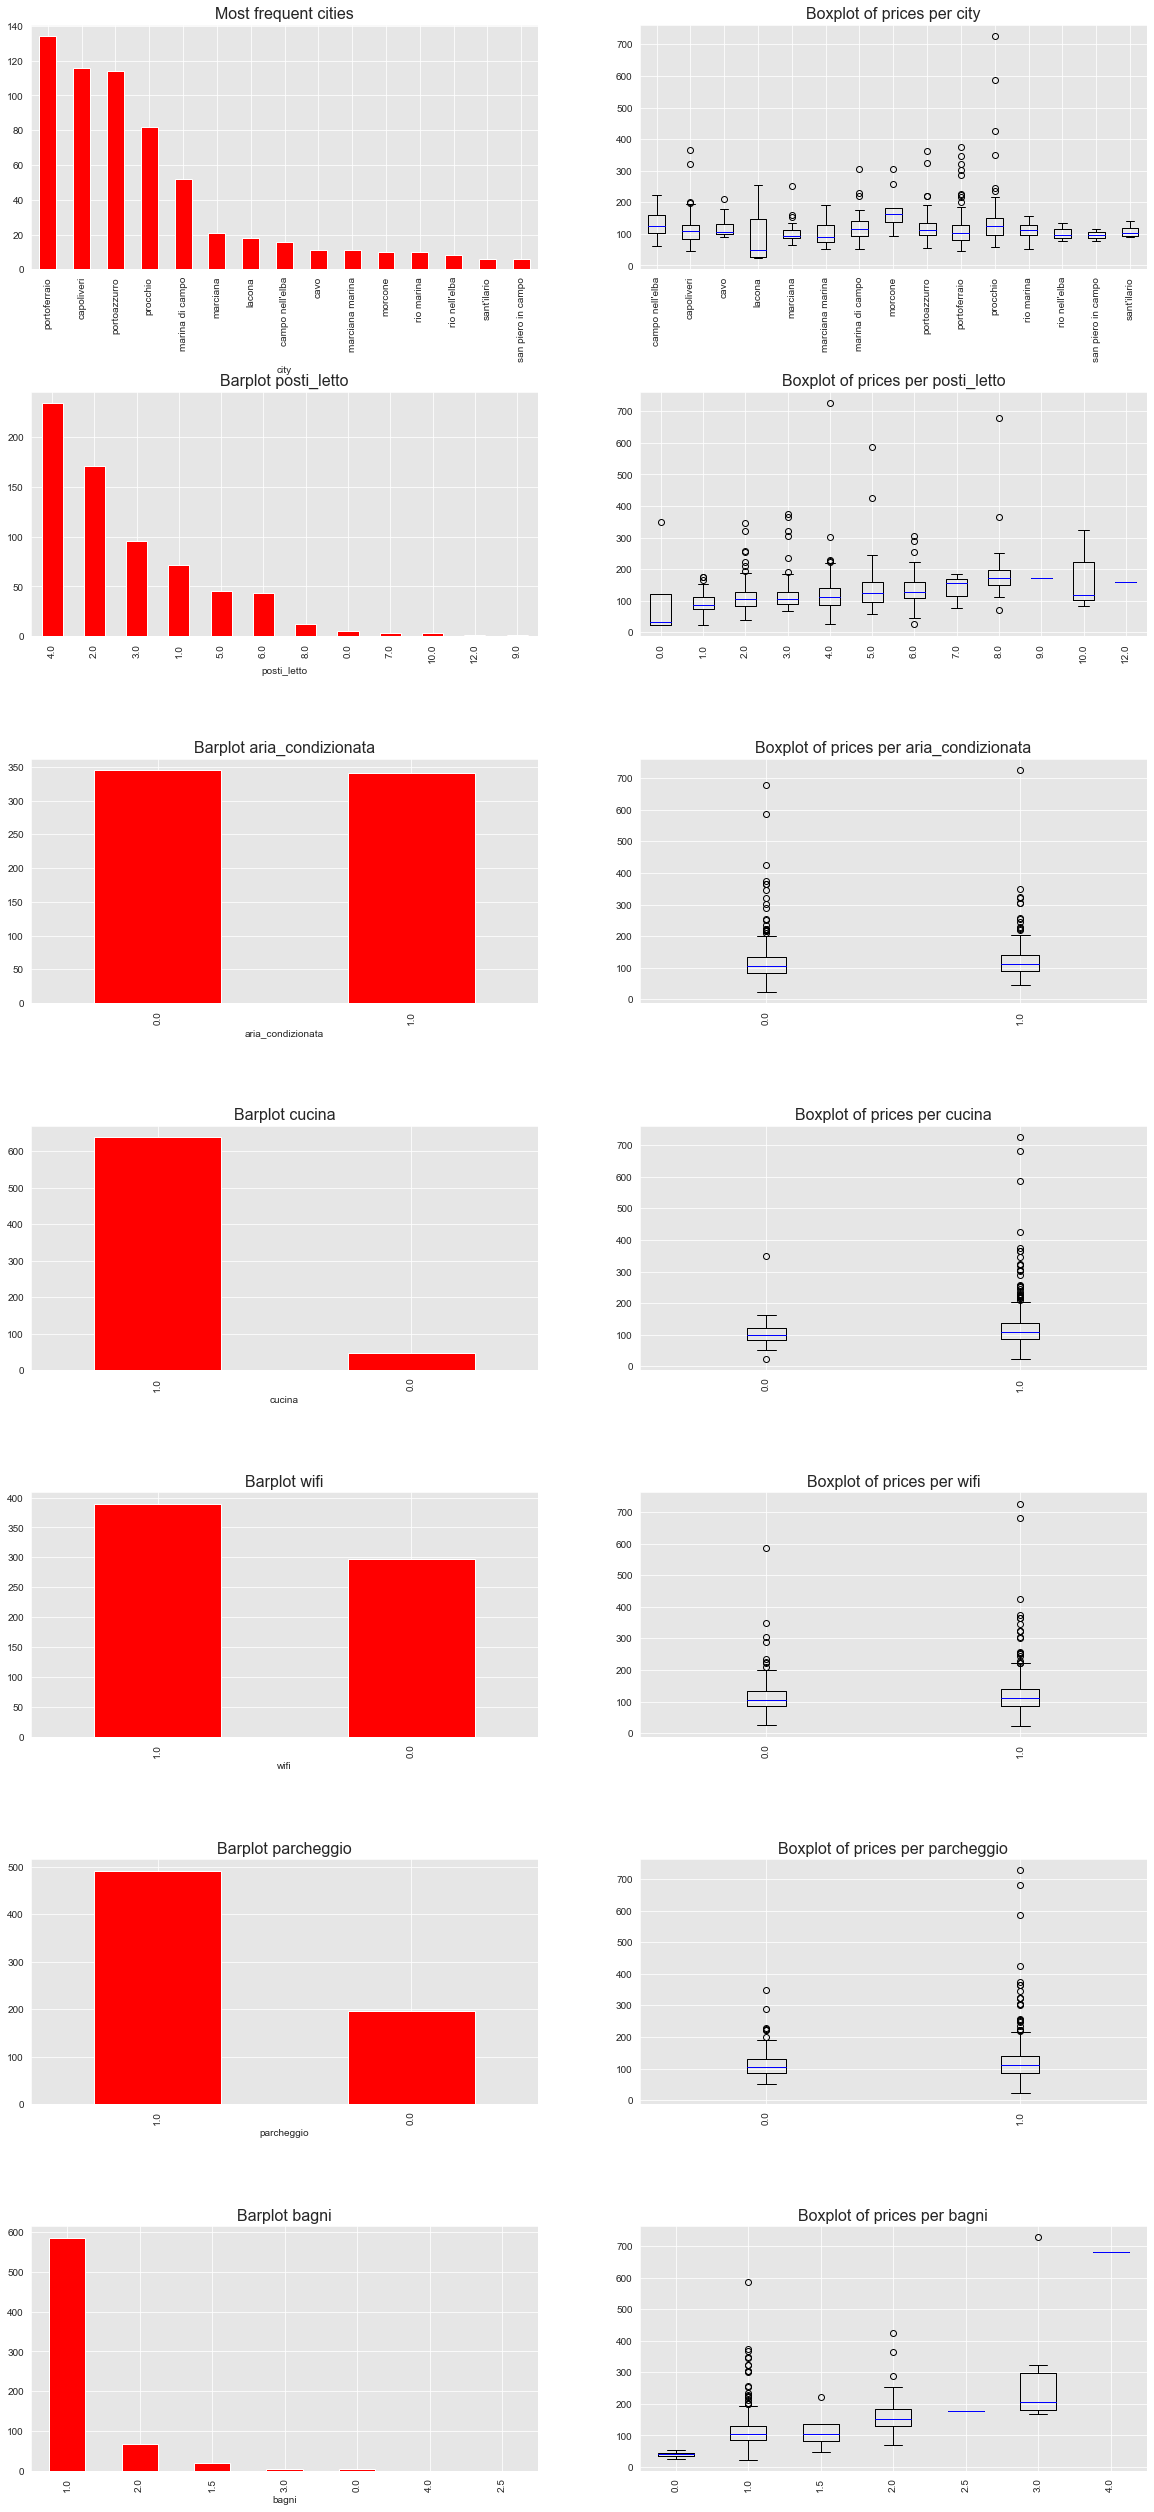

In [36]:
fig, ax = plt.subplots(7, 2, figsize = (20, 45))
# Imposta lo spazio verticale tra i subplots
plt.subplots_adjust(hspace = 0.5)

# AXES [0,0] e [0,1]
cities_to_plot = df['city'].value_counts().head(15).index.to_list()
mask = df['city'].isin(cities_to_plot)
# Barplot
df[mask]['city'].value_counts().plot(kind = 'bar', ax = ax[0,0], color = 'red')
# Boxplot
df[mask].plot(kind = 'box', column = 'price', by = 'city', ax = ax[0,1], color = 'black', medianprops={'color': 'blue'})
ax[0,0].set_title('Most frequent cities', size = 16)
ax[0,1].set_title('Boxplot of prices per city', size = 16)
ax[0,1].tick_params(axis = 'x', rotation = 90)

# AXES [1,0] e [1,1]
# Barplot
df['posti_letto'].value_counts().plot(kind = 'bar', ax = ax[1,0], color = 'red')
# Boxplot
df.plot(kind = 'box', column = 'price', by = 'posti_letto', ax = ax[1,1], color = 'black', medianprops={'color': 'blue'})
ax[1,0].set_title('Barplot posti_letto', size = 16)
ax[1,1].set_title('Boxplot of prices per posti_letto', size = 16)
ax[1,1].tick_params(axis = 'x', rotation = 90)

# AXES [2,0] e [2,1]
# Barplot
df['aria_condizionata'].value_counts().plot(kind = 'bar', ax = ax[2,0], color = 'red')
# Boxplot
df.plot(kind = 'box', column = 'price', by = 'aria_condizionata', ax = ax[2,1], color = 'black', medianprops={'color': 'blue'})
ax[2,0].set_title('Barplot aria_condizionata', size = 16)
ax[2,1].set_title('Boxplot of prices per aria_condizionata', size = 16)
ax[2,1].tick_params(axis = 'x', rotation = 90)

# AXES [3,0] e [3,1]
# Barplot
df['cucina'].value_counts().plot(kind = 'bar', ax = ax[3,0], color = 'red')
# Boxplot
df.plot(kind = 'box', column = 'price', by = 'cucina', ax = ax[3,1], color = 'black', medianprops={'color': 'blue'})
ax[3,0].set_title('Barplot cucina', size = 16)
ax[3,1].set_title('Boxplot of prices per cucina', size = 16)
ax[3,1].tick_params(axis = 'x', rotation = 90)

# AXES [4,0] e [4,1]
# Barplot
df['wifi'].value_counts().plot(kind = 'bar', ax = ax[4,0], color = 'red')
# Boxplot
df.plot(kind = 'box', column = 'price', by = 'wifi', ax = ax[4,1], color = 'black', medianprops={'color': 'blue'})
ax[4,0].set_title('Barplot wifi', size = 16)
ax[4,1].set_title('Boxplot of prices per wifi', size = 16)
ax[4,1].tick_params(axis = 'x', rotation = 90)

# AXES [5,0] e [5,1]
# Barplot
df['parcheggio'].value_counts().plot(kind = 'bar', ax = ax[5,0], color = 'red')
# Boxplot
df.plot(kind = 'box', column = 'price', by = 'parcheggio', ax = ax[5,1], color = 'black', medianprops={'color': 'blue'})
ax[5,0].set_title('Barplot parcheggio', size = 16)
ax[5,1].set_title('Boxplot of prices per parcheggio', size = 16)
ax[5,1].tick_params(axis = 'x', rotation = 90)

# AXES [6,0] e [6,1]
# Barplot
df['bagni'].value_counts().plot(kind = 'bar', ax = ax[6,0], color = 'red')
# Boxplot
df.plot(kind = 'box', column = 'price', by = 'bagni', ax = ax[6,1], color = 'black', medianprops={'color': 'blue'})
ax[6,0].set_title('Barplot bagni', size = 16)
ax[6,1].set_title('Boxplot of prices per bagni', size = 16)
ax[6,1].tick_params(axis = 'x', rotation = 90)

plt.show()

### 2) Dettagli di spesa

In [37]:
df.sort_values(by = 'spesa_overall', ascending = False)[['notti', 'spesa_overall', 'spesa_host',
                                                         'sconto', 'spesa_pulizie', 'spesa_service']]

,notti,spesa_overall,spesa_host,sconto,spesa_pulizie,spesa_service
470,5.0,3634.0,3000.0,0.0,100.0,534.0
133,5.0,3399.0,2500.0,0.0,400.0,499.0
481,7.0,2970.0,2730.0,0.0,60.0,88.0
487,5.0,2931.0,2500.0,0.0,60.0,431.0
646,6.0,2192.0,1800.0,0.0,70.0,322.0
...,...,...,...,...,...,...
16,5.0,127.0,127.0,0.0,60.0,88.0
9,5.0,127.0,127.0,0.0,60.0,88.0
30,5.0,122.0,122.0,0.0,60.0,88.0
23,5.0,115.0,115.0,0.0,60.0,88.0


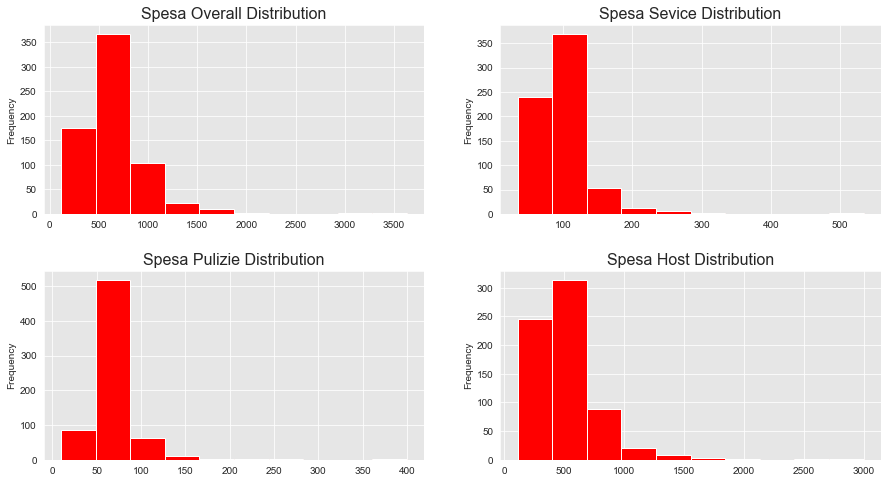

In [38]:
fig, ax = plt.subplots(2, 2, figsize = (15, 8))
# Imposta lo spazio verticale tra i subplots
plt.subplots_adjust(hspace = 0.3)

df['spesa_overall'].plot(kind = 'hist', ax = ax[0,0], color = 'red')
df['spesa_service'].plot(kind = 'hist', ax = ax[0,1], color = 'red')
df['spesa_pulizie'].plot(kind = 'hist', ax = ax[1,0], color = 'red')
df['spesa_host'].plot(kind = 'hist', ax = ax[1,1], color = 'red')

ax[0,0].set_title('Spesa Overall Distribution', size = 16)
ax[0,1].set_title('Spesa Sevice Distribution', size = 16)
ax[1,0].set_title('Spesa Pulizie Distribution', size = 16)
ax[1,1].set_title('Spesa Host Distribution', size = 16)

plt.show()

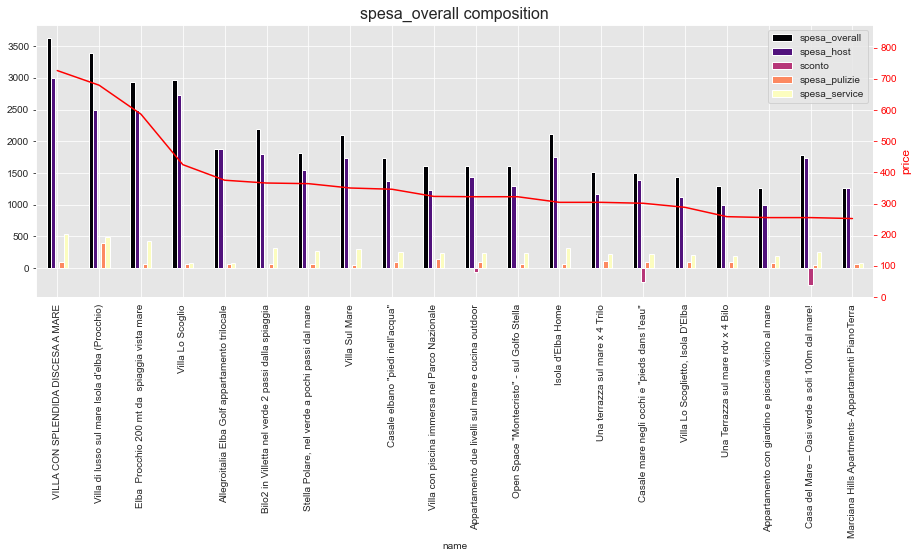

In [39]:
fig, ax = plt.subplots(1, figsize = (15, 5))

df_plot = df.sort_values(by = 'price', ascending = False).set_index('name').head(20)

(df_plot[['spesa_overall', 'spesa_host', 'sconto', 'spesa_pulizie', 'spesa_service']]
 .plot(kind = 'bar', stacked = False, ax = ax, cmap = 'magma'))

ax.set_title('spesa_overall composition', size = 16)
ax_t = ax.twinx()
ax_t.tick_params(axis = 'y', color = 'red', labelcolor = 'red')
ax_t.set_ylabel('price', fontsize = 12, c = 'red')
df_plot['price'].plot(kind = 'line', ax = ax_t, color = 'red')
ax_t.grid(False)
ax_t.set_ylim(0, max(df_plot['price']*1.2))


plt.show()

### 3) Mappa con folium

In [40]:
colors = ['lightgreen', 'green', 'orange', 'pink', 'red', 'black']
quantiles = [df['price'].quantile(j) for j in np.linspace(1/len(colors), 1, len(colors)+1)]
dict_price_color = dict(zip(quantiles, colors))

def calc_marker_color(input_dict, price):
    color = input_dict[list(input_dict.keys())[0]]
    for p in input_dict:
        if price > p:
            color = input_dict[p] 
    return(color)

In [41]:
# Creo l'oggetto mappa 
centering_params = (df['lat'].mean(), df['long'].mean())
mappa = folium.Map(tiles = 'OpenStreetMap', location = centering_params, zoom_start = 11.5)

# Per ogni annuncio creato vado a posizionarlo sulla mappa
for idx in df.index:
    name = df.loc[idx, 'name']
    price = df.loc[idx, 'price']
    lat = df.loc[idx, 'lat']
    long = df.loc[idx, 'long']
    rating_verbose = df.loc[idx, 'rating_verbose']
    checkin = df.loc[idx, 'checkin']
    checkout = df.loc[idx, 'checkout']
    spesa_overall = df.loc[idx, 'spesa_overall']
    
    len_box = max( len(str(checkin)) + len(str(checkout)) + 8, len(name))
    # Faccio in modo che per ogni icona passandoci sopra il mouse compaia la descrizione
    tooltip = f"""
    <div style="width: {5*len_box}px; height: 55px">
    <h7> {name}<br>{price} €/gg</h7 <br> - rating: {rating_verbose}<br>{checkin} <---> {checkout} 
    <h7> <br> spesa_overall: {spesa_overall} €
    </div>
    """
# Aggiungo i marker alla cartina
    folium.Marker([lat, long], 
                  tooltip = tooltip,
                  icon = folium.Icon(color = calc_marker_color(dict_price_color, price), icon = 'home')).add_to(mappa)
mappa

In [42]:
# Salvo mappa
mappa.save(r'C:\Users\peria\Desktop\GitHub\AirBnB_Price_Analysis\Elba\mappa.html')

### 4) Distanza dalle principali attrazioni

In [43]:
from geopy.distance import geodesic

In [44]:


dict_attrazioni = {'Cavoli': [10, [42.737243, 10.186494]],
                   'Fetovaia': [10, [42.732767, 10.153503]],
                   'Campo': [8, [42.745598, 10.235646]],
                   'Seccheto': [6, [42.736150, 10.176588]],
                   #'Palombaia': [5, [42.735822, 10.203706]],
                   #'Chiessi': [5, [42.759647, 10.111083]],
                   'Pomonte': [5, [42.745718, 10.119317]],
                   #'Patresi': [7, [42.792480, 10.109756]],
                   "Sant'Andrea": [7, [42.807282, 10.141120]],
                   #'Crocetta': [3, [42.806056, 10.206778]],
                   #'Bagno': [8, [42.795508, 10.217021]],
                   'Paolina': [7, [42.788076, 10.232289]],
                   #'Spartaia': [5, [42.787405, 10.236698]],
                   'Procchio': [7, [42.787828, 10.243773]],
                   "Campo all'Aia": [4, [42.792996, 10.249382]],
                   'Biodola': [9, [42.799531, 10.264973]],
                   'Forno': [7, [42.807738, 10.267840]],
                   'Viticcio': [7, [42.817023, 10.275106]],
                   'Enfola': [7, [42.824716, 10.268918]],
                   'Sansone': [10, [42.822816, 10.280261]],
                   'Prunini': [7, [42.818774, 10.296996]],
                   'Sottobomba': [8, [42.819049, 10.307412]],
                   'Capo Bianco': [9, [42.820356, 10.313593]],
                   'Padulella': [9, [42.819859, 10.316321]],
                   'Ghiaie': [9, [42.817462, 10.323916]],
                   'Bagnaia': [5, [42.810927, 10.363184]],
                   'Nisporto': [5, [42.825733, 10.378603]],
                   #'Frugoso': [4, [42.866930, 10.418675]],
                   'Cavo': [6, [42.862509, 10.420464]],
                   #'Direttore': [5, [42.847339, 10.442859]],
                   'Cala Seregola': [6, [42.842076, 10.441706]],
                   'Toponetti': [6, [42.836761, 10.437998]],
                   #'Ripa Bianca': [5, [42.831555, 10.435354]],
                   'Terranera': [7, [42.773782, 10.419969]],
                   #'Porticciolo': [3, [42.803044, 10.431846]],
                   #'Ortano': [4, [42.793837, 10.429604]],
                   'Barbarossa': [7, [42.769428, 10.408117]],
                   'Naregno': [6, [42.755027, 10.402932]],
                   'Straccoligno': [5, [42.748091, 10.405993]],
                   'Remaiolo': [6, [42.715732, 10.413087]],
                   'Innamorata': [8, [42.721794, 10.377093]],
                   #'Cannello': [6, [42.713859, 10.400571]], 
                   'Pareti': [5, [42.727993, 10.375387]],
                   #'Morcone': [6, [42.731705, 10.373142]],
                   #'Stecchi': [6, [42.743967, 10.363446]],
                   'Barabarca': [7, [42.748326, 10.361010]],
                   'Zuccale': [6,[42.750302, 10.359337]],
                   #'Calanchiole': [4, [42.758546, 10.358182]],
                   'Lido': [8, [42.760433, 10.355396]], 
                   'Felciaio': [7, [42.762779, 10.349129]],
                   'Norsi': [8, [42.763986, 10.343172]],
                   #'Acquerilli': [8, [42.763656, 10.335555]],
                   'Margidore': [7, [42.759708, 10.318135]],
                   'Lacona': [10, [42.759679, 10.307111]],
                   'Laconella': [8, [42.756727, 10.295533]],
                   #'Fonza': [6, [42.745050, 10.262394]]
                  }

def calc_distance_indicator(x, dict_attrazioni):
    coord_x = [x['lat'], x['long']]
    sum_weights = 0
    for j in dict_attrazioni.keys():
        sum_weights += dict_attrazioni[j][0]
    risu = 0
    for j in dict_attrazioni.keys():
        risu += dict_attrazioni[j][0] * geodesic(coord_x, dict_attrazioni[j][1]).kilometers
    risu = risu / sum_weights    
    return risu

df['dist_indicator'] = df.apply(lambda x: calc_distance_indicator(x, dict_attrazioni), axis = 1)

In [45]:
df.sort_values(by = 'dist_indicator', ascending = True)[['name', 'price', 'dist_indicator']].head()

,name,price,dist_indicator
207,Appartamento Santa Lucia - Primo Piano,70.0,6.965582
141,Trilocale Casa Gialla Isola d' Elba,106.0,7.002738
77,Relax nel villino di Fanny,88.0,7.003648
278,Bilocale Casa Verde Isola d' Elba,75.0,7.007358
105,Ca’ Bianca,120.0,7.012797


In [46]:
X1 = 1/df['dist_indicator'].values
X2 = 1/(df['dist_indicator']**2).values
X3 = 1/(df['dist_indicator']**3).values
X4 = 1/(df['dist_indicator']**4).values
X5 = 1/(df['dist_indicator']**5).values
X6 = 1/(df['dist_indicator']**6).values

X_train = np.column_stack([X1, X2, X3, X4, X5, X6])
y_train = df['price']

In [47]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
W = model.coef_
b = model.intercept_
W, b

(array([-5.21671091e+05,  1.53563865e+07, -2.33863240e+08,  1.94377766e+09,
        -8.36298397e+09,  1.45634064e+10]),
 7270.635479180619)

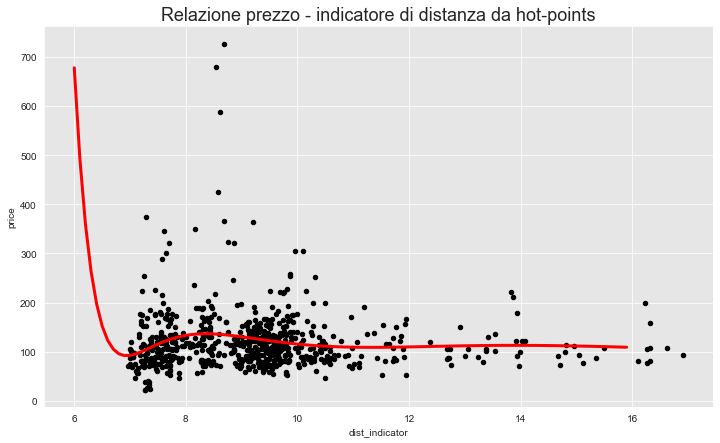

In [48]:
fig, ax = plt.subplots(figsize = (12, 7)) 
df[['price', 'dist_indicator']].plot(x = 'dist_indicator', y = 'price', kind = 'scatter', ax = ax, color = 'black')

ascisse = np.arange(int(df['dist_indicator'].min()), int(df['dist_indicator'].max()), 0.1)
X1 = 1/ascisse
X2 = 1/(ascisse)**2
X3 = 1/(ascisse)**3
X4 = 1/(ascisse)**4
X5 = 1/(ascisse)**5
X6 = 1/(ascisse)**6

X_train = np.column_stack([X1, X2, X3, X4, X5, X6])
ordinate = model.predict(X_train)

ax.plot(ascisse, ordinate, color = 'red', linewidth = 3)
    
ax.set_title('Relazione prezzo - indicatore di distanza da hot-points', size = 18)
plt.show()

In [49]:
# Creo l'oggetto mappa
df_price_distance = df.sort_values(by = ['dist_indicator'], ascending = True).head(100)
centering_params = (df_price_distance['lat'].mean(), df_price_distance['long'].mean())
mappa = folium.Map(tiles = 'OpenStreetMap', location = centering_params, zoom_start = 11.5)

# Per ogni annuncio creato vado a posizionarlo sulla mappa
for idx in df_price_distance.index:
    name = df_price_distance.loc[idx, 'name']
    price = df_price_distance.loc[idx, 'price']
    lat = df_price_distance.loc[idx, 'lat']
    long = df_price_distance.loc[idx, 'long']
    rating_verbose = df_price_distance.loc[idx, 'rating_verbose']
    checkin = df_price_distance.loc[idx, 'checkin']
    checkout = df_price_distance.loc[idx, 'checkout']
    spesa_overall = df_price_distance.loc[idx, 'spesa_overall']
    
    len_box = max( len(str(checkin)) + len(str(checkout)) + 8, len(name))
    # Faccio in modo che per ogni icona passandoci sopra il mouse compaia la descrizione
    tooltip = f"""
    <div style="width: {5*len_box}px; height: 55px">
    <h7> {name}<br>{price} €/gg</h7 <br> - rating: {rating_verbose}<br>{checkin} <---> {checkout} 
    <h7> <br> spesa_overall: {spesa_overall} €
    </div>
    """
# Aggiungo i marker alla cartina
    folium.Marker([lat, long], 
                  tooltip = tooltip,
                  icon = folium.Icon(color = 'red', icon = 'home')).add_to(mappa)
mappa

# Modello

### Distribuzione price e outlier detection

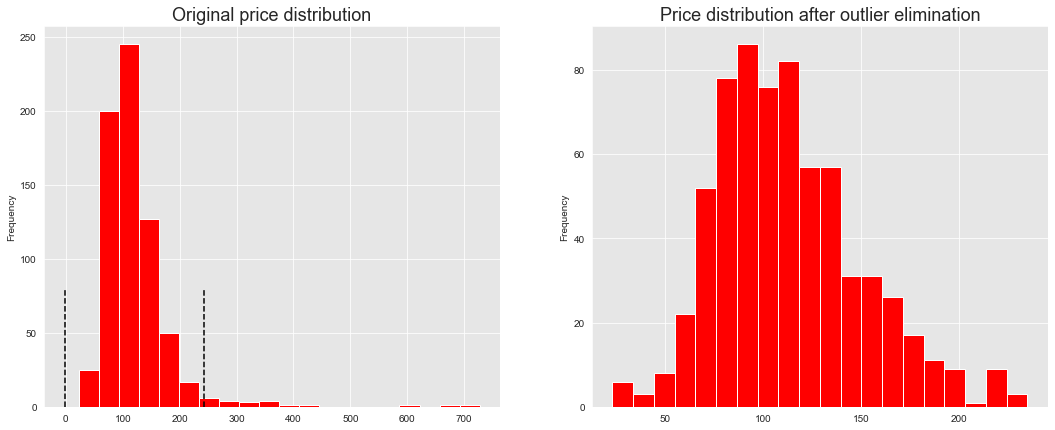

In [50]:
fig, ax = plt.subplots(1, 2, figsize = (18,7))
df['price'].plot(kind = 'hist', color = 'red', bins = 20, ax = ax[0])
ax[0].set_title('Original price distribution', fontsize = 18)
mean = df['price'].mean(axis = 0)
sd = df['price'].std(axis = 0)
ub = mean + 2*sd
lb = mean - 2*sd
ax[0].plot([lb, lb], [0, 80], linestyle = '--', color = 'black')
ax[0].plot([ub, ub], [0, 80], linestyle = '--', color = 'black')

# Sostituisco il valore estremo con l'upper e il lower bound
#df['price'] = df['price'].apply(lambda x: ub if x > ub else x)
#df['price'] = df['price'].apply(lambda x: lb if x < lb else x)

# Elimino il valore estremo
df = df[(df['price'] >= lb) & (df['price'] <= ub)]

df['price'].plot(kind = 'hist', color = 'red', bins = 20, ax = ax[1])
ax[1].set_title('Price distribution after outlier elimination', fontsize = 18)
plt.show()

### Correlation analysis

In [51]:
features = ['price', 'lat', 'long', 'rating', 'reviews', 'posti_letto', 'pulizia', 'dist_indicator']

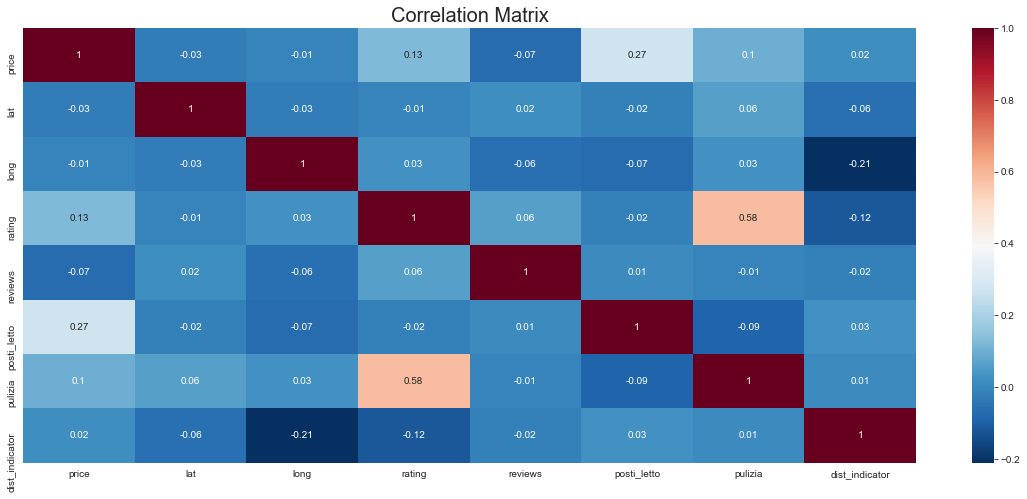

In [52]:
plt.figure(figsize=(20, 8))  # Adjust the figure size if needed
sns.heatmap(df[features].corr().round(2), annot = True, cmap = 'RdBu_r')
plt.title('Correlation Matrix', size = 20)
plt.show()

C:\Users\peria\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


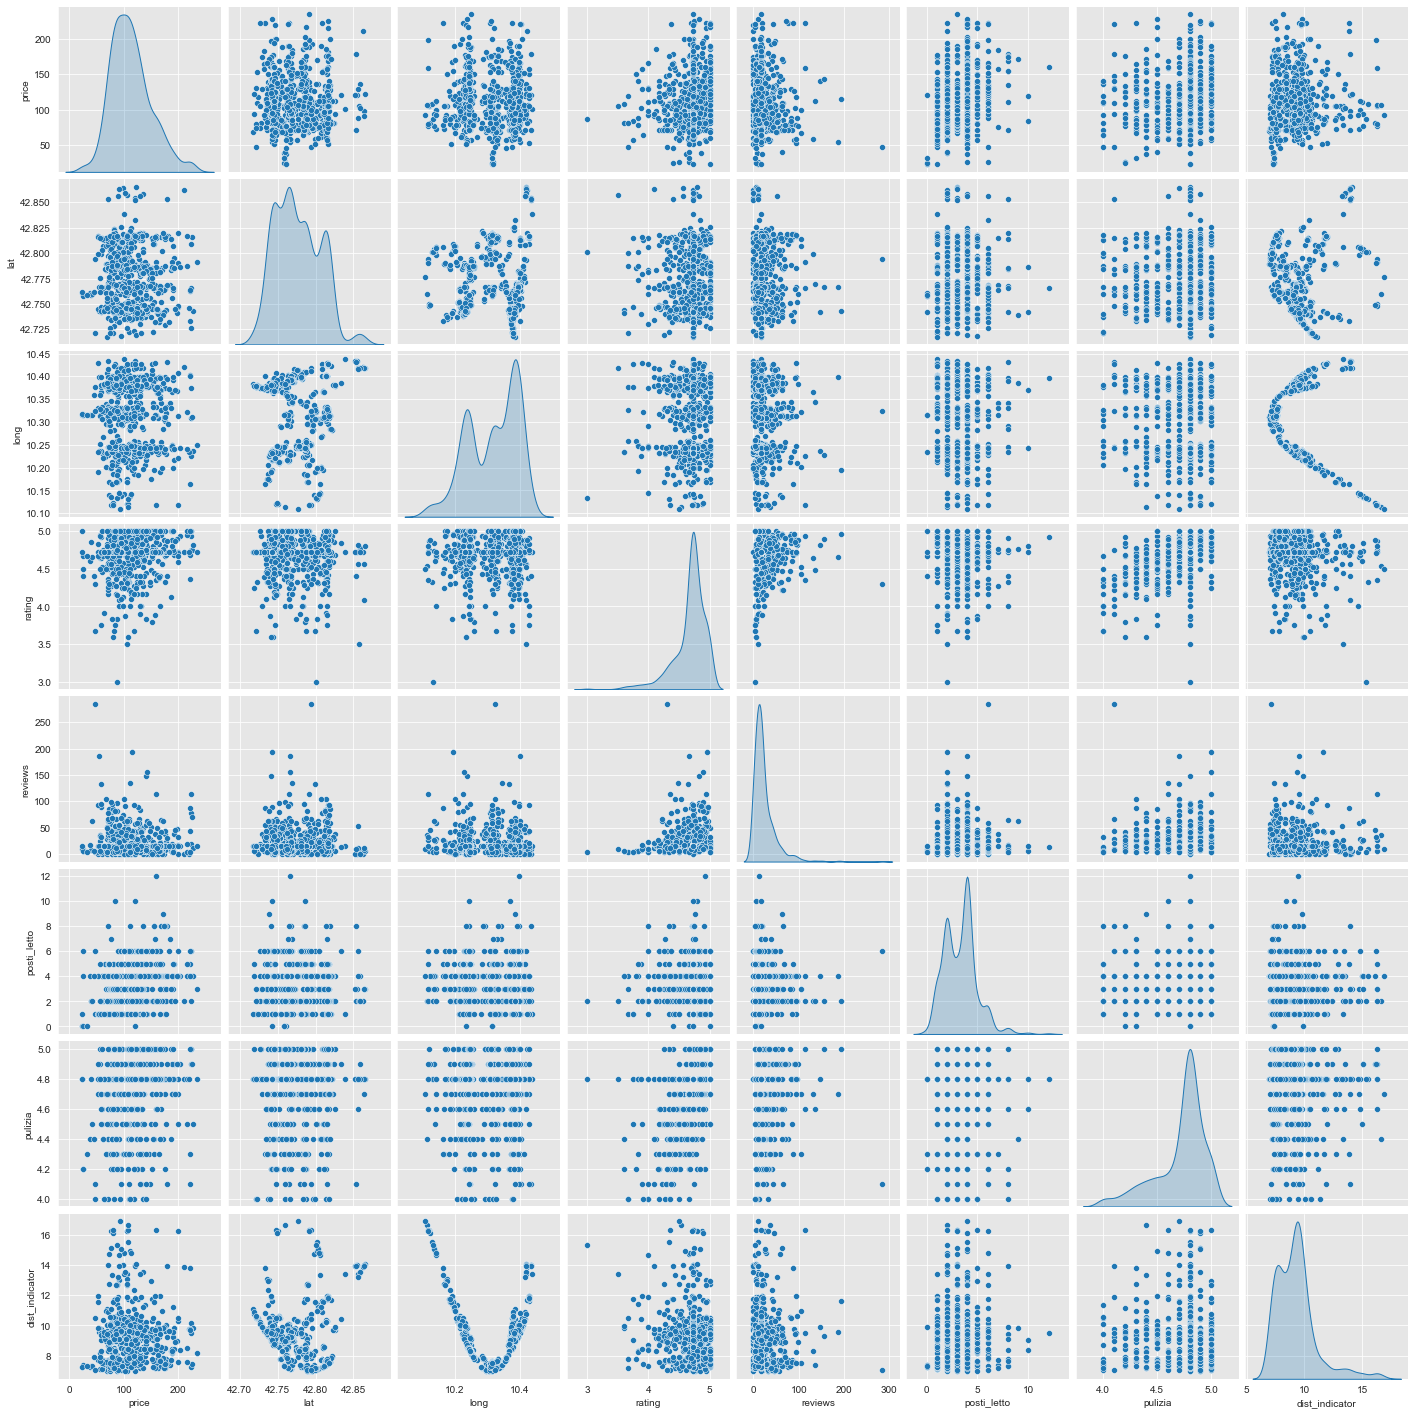

In [53]:
features = ['price', 'lat', 'long', 'rating', 'reviews', 'posti_letto', 'pulizia', 'dist_indicator']
sns.pairplot(df[features], kind = 'scatter', diag_kind = 'kde')
plt.show()

### Features

In [54]:
df = df.dropna()
df.isnull().sum()[df.isnull().sum() != 0 ]

Series([], dtype: int64)

In [55]:
df.columns

Index(['id', 'title', 'name', 'city', 'rating_verbose', 'lat', 'long',
       'obj_annuncio', 'intestatario', 'n_photo', 'list_link_photo',
       'list_amenities', 'price', 'price_verbose', 'spesa_overall',
       'spesa_host_verbose', 'spesa_host', 'sconto', 'spesa_pulizie',
       'spesa_service', 'checkin', 'checkout', 'notti', 'rating', 'reviews',
       'posti_letto', 'bagni', 'aria_condizionata', 'cucina', 'parcheggio',
       'wifi', 'pulizia', 'dist_indicator'],
      dtype='object')

In [56]:
features = ['price', 'lat', 'long', 'n_photo', 'rating', 'reviews', 'posti_letto',
            'bagni', 'cucina', 'parcheggio', 'wifi', 'pulizia', 'aria_condizionata', 'dist_indicator']

X = df[features[1:]].values
y = df[features[0]].values

### Evaluation meatrics

In [57]:
X

array([[42.76199   , 10.36358   , 10.        , ...,  5.        ,
         1.        ,  8.05081246],
       [42.76188106, 10.23297586, 18.        , ...,  4.8       ,
         0.        ,  9.23952386],
       [42.75892   , 10.31571   , 27.        , ...,  4.8       ,
         0.        ,  7.34155265],
       ...,
       [42.743782  , 10.381899  , 26.        , ...,  4.4       ,
         0.        ,  9.42796822],
       [42.74518   , 10.36752   , 30.        , ...,  5.        ,
         1.        ,  8.79787049],
       [42.74122   , 10.38077   , 19.        , ...,  4.6       ,
         0.        ,  9.50604224]])

In [58]:
# Calcolo delle metriche per valutare il modello

def calc_SE(pred, true):
    return np.sum((pred - true)**2)

def calc_MSE(pred, true):
    return np.mean((pred - true)**2)

def calc_MAE(pred, true):
    return np.mean(abs(pred - true)) 

def calc_RMSE(pred, true):
    return np.sqrt(np.mean((pred - true)**2))

def calc_R2(pred, true):
    return(1 - np.var(pred - true)/np.var(true))

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 18)

In [60]:
X_train

array([[42.80693   , 10.20179   , 20.        , ...,  4.3       ,
         1.        , 10.97931237],
       [42.76036   , 10.3848    ,  9.        , ...,  4.7       ,
         1.        ,  8.97004673],
       [42.81526   , 10.4279    , 26.        , ...,  4.1       ,
         1.        , 11.85143566],
       ...,
       [42.74896   , 10.12342   , 24.        , ...,  4.9       ,
         0.        , 16.09488793],
       [42.75035   , 10.2328    , 11.        , ...,  4.7       ,
         1.        ,  9.61985258],
       [42.74109   , 10.19081   , 15.        , ...,  4.8       ,
         1.        , 11.94942082]])

### Decision Tree

In [61]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

model = DecisionTreeRegressor()
dist = {'criterion': ['squared_error'],
        'splitter': ['best', 'random'],
        'max_depth' : range(10, 40),
        'min_samples_split' : range(2, 25),
        'min_samples_leaf' : range(1, 20),
        'min_impurity_decrease': np.linspace(1, 100, 25),
        'random_state': [108],
        }

model_Opt = RandomizedSearchCV(model, # lo stimatore scelto
                               param_distributions = dist, # la distribuzione dei parametri da testare
                               scoring = 'neg_mean_squared_error', # lo score in base a cui ottimizzare i parametri
                               cv = 10, # Fold della Cross Validation
                               verbose = 3, # 1, 2, o 3 a secoda di quanto vuoi che scriva man mano che testa
                               n_iter = 100, # numero di iterazioni considerate
                               n_jobs = -1, # mandare tutti i processori in parallelo
                               refit = True, # refittare lo stimatore in base alla migliore combinazione di parametri testata
                               return_train_score = True)

In [62]:
# Fitto il modello ottimizzato sui dati di training
model_Opt.fit(X_train, y_train)
# Visualizzare i migliori parametri
model_Opt.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


{'splitter': 'best',
 'random_state': 108,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 46.375,
 'max_depth': 32,
 'criterion': 'squared_error'}

In [63]:
# Eseguo predizione sugli stessi dati di training per valutare il fitting
y_train_pred = model_Opt.predict(X_train)
# Eseguo preduzione sui dati di test per valutare la performance di previsione
y_pred = model_Opt.predict(X_test)

In [64]:
R2 = calc_R2(y_train_pred, y_train).round(4)
MAE_train = calc_MAE(y_train_pred, y_train).round(2)
RMSE_train = calc_RMSE(y_train_pred, y_train).round(2)
MAE_test = calc_MAE(y_pred, y_test)
RMSE_test = calc_RMSE(y_pred, y_test)
print(f'R2_score: {R2}\n')
print(f'TRAIN METRICS:\nMAE_train: {MAE_train}\nRMSE_train: {RMSE_train}')
print(f'\nTEST METRICS:\nMAE_test: {MAE_test}\nRMSE_test: {RMSE_test}')

R2_score: 0.1889

TRAIN METRICS:
MAE_train: 25.83
RMSE_train: 32.92

TEST METRICS:
MAE_test: 27.3162325748267
RMSE_test: 35.79465771829296


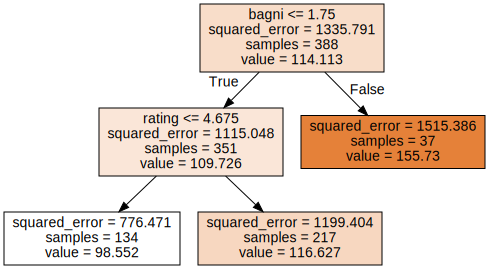

In [65]:
import os
os.environ['PATH'] += os.pathsep + r'C:\Users\peria\Desktop\PYTHON\Graphviz\bin'

from sklearn.tree import export_graphviz
export_graphviz(model_Opt.best_estimator_, out_file='tree.dot', feature_names = features[1:], impurity = True, filled = True)

import graphviz
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

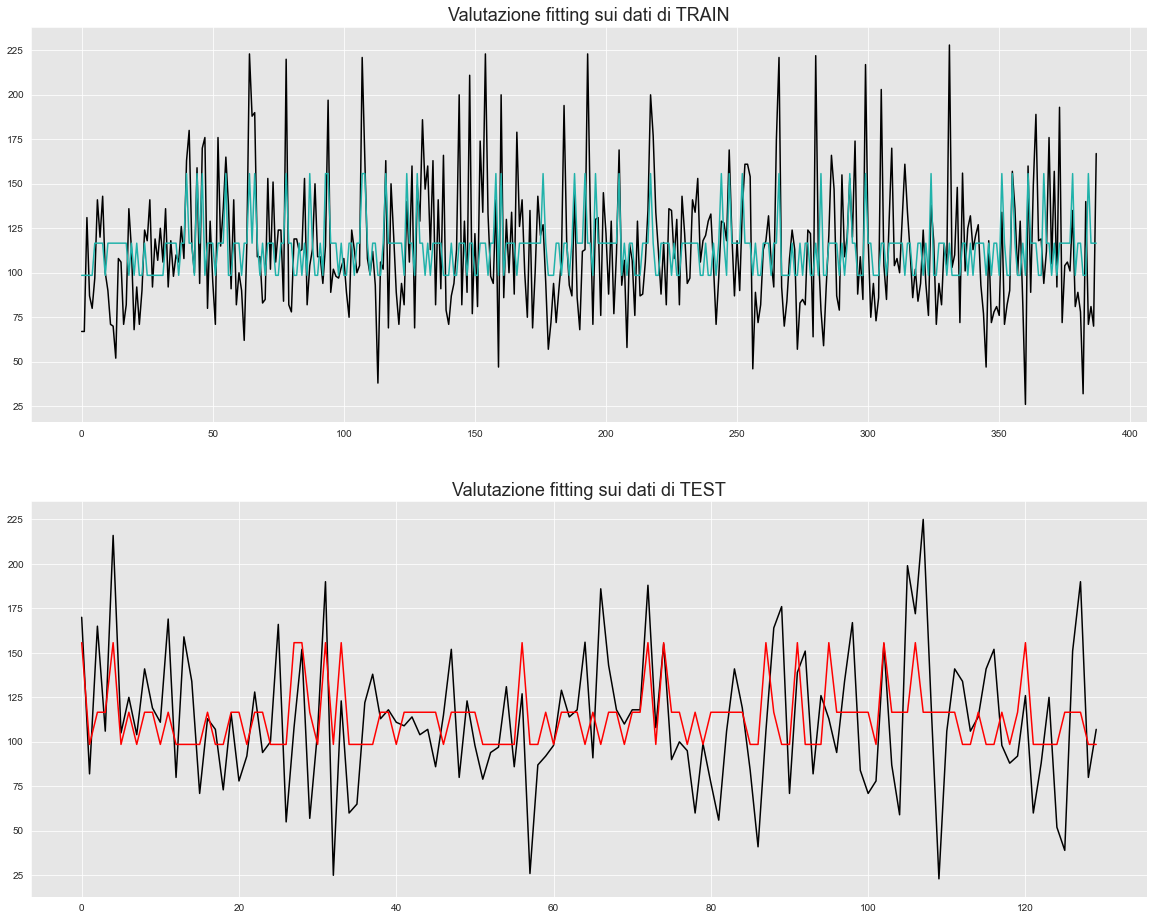

In [66]:
fig, ax = plt.subplots(2, 1, figsize = (20, 16) )
ax[0].plot(y_train, color = 'black')
ax[0].plot(y_train_pred, color = 'lightseagreen')
ax[0].set_title('Valutazione fitting sui dati di TRAIN', fontsize = 18)
ax[1].plot(y_test, color = 'black')
ax[1].plot(y_pred, color = 'red')
ax[1].set_title('Valutazione fitting sui dati di TEST', fontsize = 18)
plt.show()

In [67]:
# Eseguo il cost complexity prunuing ottenendo per ogni iterazione il corrispondente valore di alpha e la corrispndente
# metrica di errore che corrisponde al tree che corrisponde a quello specifico alpha
ccp_path = model.cost_complexity_pruning_path(X_train, y_train)
(alphas, tree_impurities) = ccp_path.ccp_alphas, ccp_path.impurities
print(f'Durante il processo di CCP ottengo :\n\nalphas:\n{alphas}\n\ntree_impurities:\n{tree_impurities}')

Durante il processo di CCP ottengo :

alphas:
[0.00000000e+00 1.28865979e-03 1.28865979e-03 1.28865979e-03
 1.28865979e-03 1.28865979e-03 1.28865979e-03 1.28865979e-03
 1.28865979e-03 1.28865979e-03 1.28865979e-03 1.28865979e-03
 1.28865979e-03 1.28865979e-03 1.28865979e-03 1.28865979e-03
 1.28865979e-03 1.28865979e-03 1.28865979e-03 1.71821306e-03
 1.71821306e-03 1.71821306e-03 1.93298969e-03 3.86597938e-03
 3.86597938e-03 5.15463918e-03 5.15463918e-03 5.15463918e-03
 5.15463918e-03 5.15463918e-03 5.15463918e-03 5.15463918e-03
 5.15463918e-03 5.15463918e-03 5.15463918e-03 5.15463918e-03
 5.15463918e-03 5.15463918e-03 5.15463918e-03 5.15463918e-03
 5.15463918e-03 6.87285223e-03 6.87285223e-03 1.15979381e-02
 1.15979381e-02 1.15979381e-02 1.15979381e-02 1.15979381e-02
 1.15979381e-02 1.15979381e-02 1.15979381e-02 1.54639175e-02
 1.54639175e-02 1.54639175e-02 2.06185567e-02 2.06185567e-02
 2.06185567e-02 2.06185567e-02 2.06185567e-02 2.06185567e-02
 2.06185567e-02 2.06185567e-02 2.061855

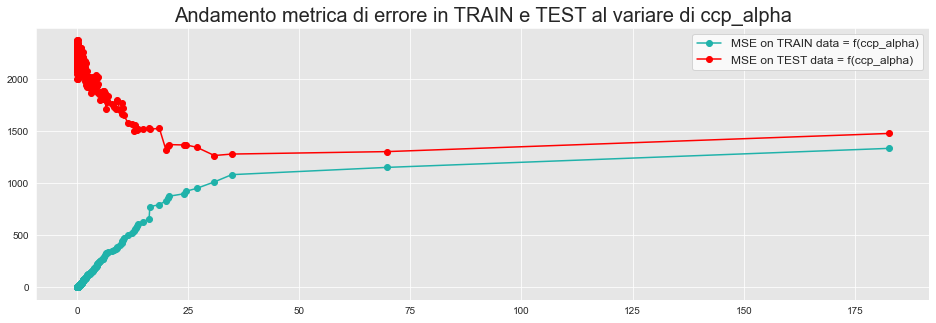

In [68]:
list_test_impurities = []
list_train_impurities = []
for a in alphas:
    # per ogni alpha addestro un differente DT e ne valuto i risultati in termini di accuratezza sia su train che su test
    # in modo da plottarli e scegliere il punto in cui i risultati sui train cominciano a staccarsi dai risultati sul test.
    # In quel punto ho trovato alpha in cui l'albero inizia ad overfittare
    ccp_model = DecisionTreeRegressor(criterion = 'squared_error', ccp_alpha = a)
    ccp_model.fit(X_train, y_train)
    # Appendo alla lista il fitting del modello sui dati di TRAIN
    y_train_pred = ccp_model.predict(X_train)
    list_train_impurities.append(calc_MSE(y_train_pred, y_train))
    # Appendo alla lista la previsione sui dati di TEST
    y_pred = ccp_model.predict(X_test)
    list_test_impurities.append(calc_MSE(y_pred, y_test))
    
fig, ax = plt.subplots(1, figsize = (16, 5))
ax.plot(alphas, list_train_impurities, color = 'lightseagreen', marker = 'o', label = 'MSE on TRAIN data = f(ccp_alpha)') # plot dei risultati di TRAIN
ax.plot(alphas, list_test_impurities, color = 'red', marker = 'o', label = 'MSE on TEST data = f(ccp_alpha)') # plot dei risultati di TEST
ax.legend(fontsize = 12, facecolor = 'white')
ax.set_title('Andamento metrica di errore in TRAIN e TEST al variare di ccp_alpha', fontsize = 20)
plt.show()

In [69]:
model = DecisionTreeRegressor(criterion = 'squared_error', ccp_alpha = 17)
model.fit(X_train, y_train)
# Eseguo predizione sugli stessi dati di training per valutare il fitting
y_train_pred = model.predict(X_train)
# Eseguo preduzione sui dati di test per valutare la performance di previsione
y_pred = model.predict(X_test)

R2 = calc_R2(y_train_pred, y_train).round(4)
MAE_train = calc_MAE(y_train_pred, y_train).round(2)
RMSE_train = calc_RMSE(y_train_pred, y_train).round(2)
MAE_test = calc_MAE(y_pred, y_test)
RMSE_test = calc_RMSE(y_pred, y_test)
print(f'R2_score: {R2}\n')
print(f'TRAIN METRICS:\nMAE_train: {MAE_train}\nRMSE_train: {RMSE_train}')
print(f'\nTEST METRICS:\nMAE_test: {MAE_test}\nRMSE_test: {RMSE_test}')

R2_score: 0.4188

TRAIN METRICS:
MAE_train: 21.82
RMSE_train: 27.86

TEST METRICS:
MAE_test: 28.664855719748196
RMSE_test: 38.981152668241066


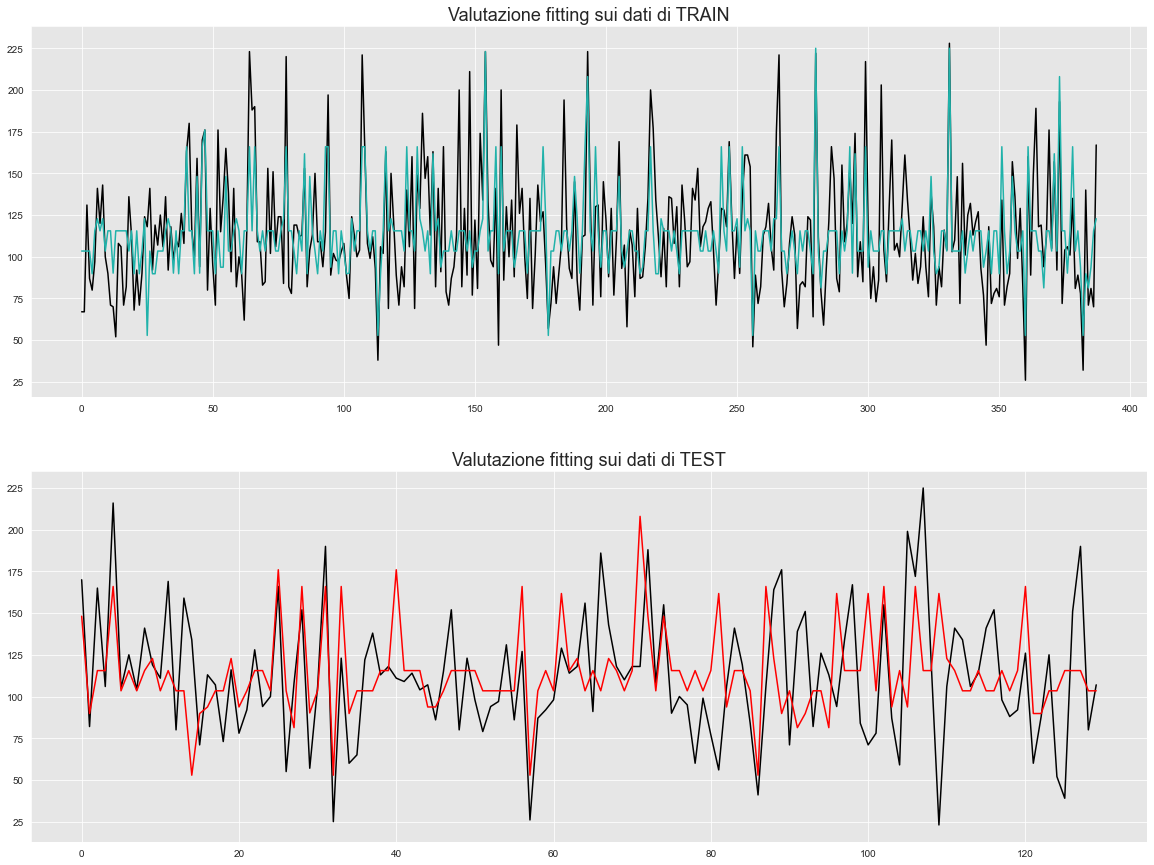

In [70]:
fig, ax = plt.subplots(2, 1, figsize = (20, 15) )
ax[0].plot(y_train, color = 'black')
ax[0].plot(y_train_pred, color = 'lightseagreen')
ax[0].set_title('Valutazione fitting sui dati di TRAIN', fontsize = 18)
ax[1].plot(y_test, color = 'black')
ax[1].plot(y_pred, color = 'red')
ax[1].set_title('Valutazione fitting sui dati di TEST', fontsize = 18)
plt.show()

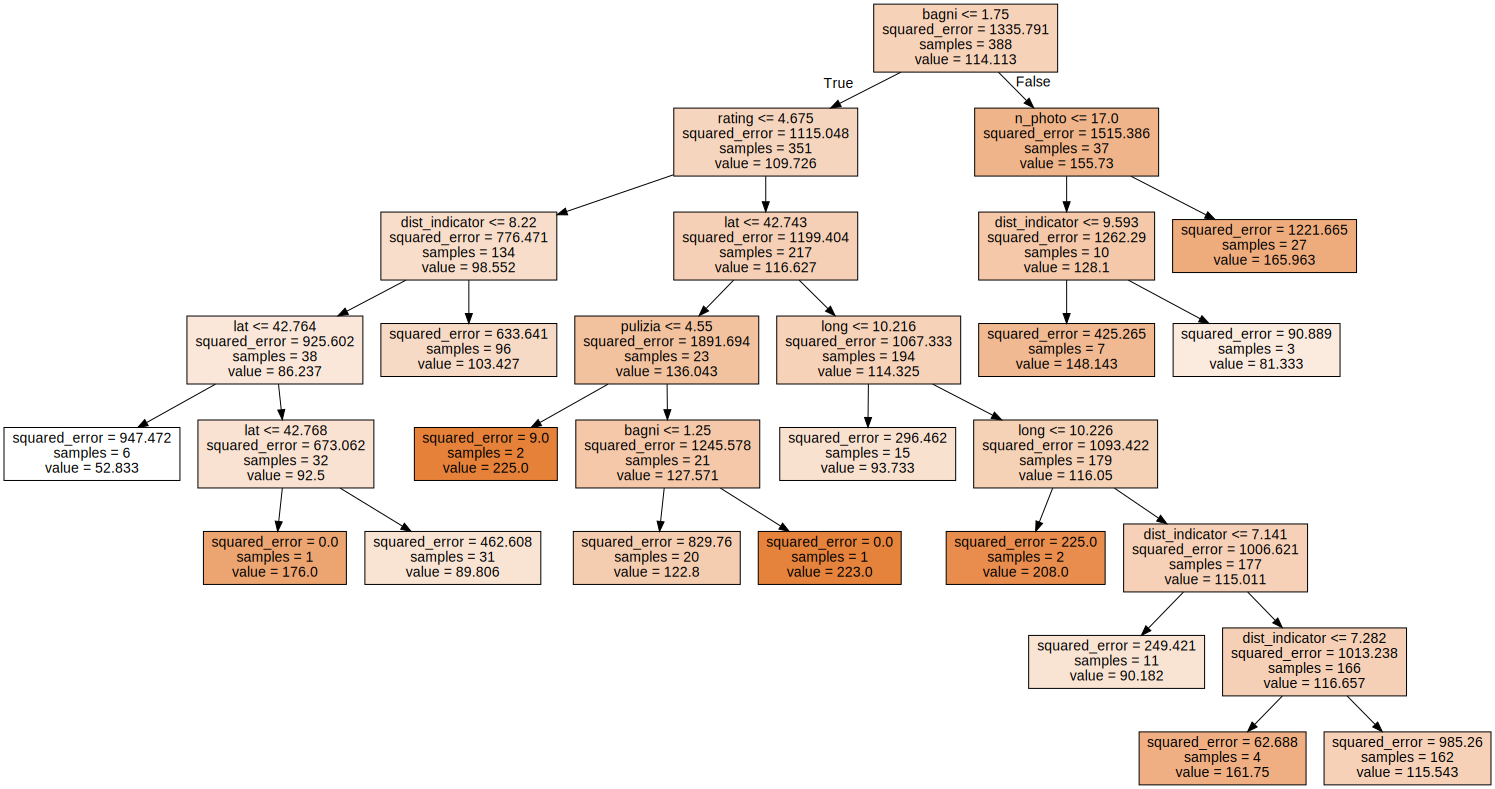

In [71]:
export_graphviz(model, out_file='tree.dot', feature_names = features[1:], impurity = True, filled = True)
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)